In [1]:
import numpy as np
import tensorflow as tf
import os
import pickle
import matplotlib.pyplot as plt
import dlib
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance

import facenet
import detect_face

%matplotlib inline

In [2]:
model_path = '../model/20170512-110547'
image_dir_basepath = '/home/charmer/Workspace/'

image_size = 160

In [3]:
# image_dirpath = os.path.abspath(image_dir_basepath + 'images_taniai/')
# image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]

# img_num = 0
# img = imread(image_filepaths[img_num])

# plt.imshow(img)

In [4]:
# margin = 0

# detector = dlib.get_frontal_face_detector()
# faces = detector(img, 1)

# skipMulti = False
# if (not skipMulti and len(faces) > 0) or len(faces) == 1:
#     bb = max(faces, key=lambda rect: rect.width() * rect.height())
    
# cropped = img[bb.top()-margin//2:bb.bottom()+margin//2,
#               bb.left()-margin//2:bb.right()+margin//2, :]
# aligned = resize(cropped, (image_size, image_size), mode='reflect')
# prewhitened = facenet.prewhiten(aligned)

# plt.imshow(aligned)

In [5]:
def load_and_align_images(image_filepaths, margin):
    detector = dlib.get_frontal_face_detector()

    aligned_images = []
    for image_filepath in image_filepaths:
        try:
            img = imread(image_filepath)
            faces = detector(img, 1)

            skipMulti = False
            if (not skipMulti and len(faces) > 0) or len(faces) == 1:
                bb = max(faces, key=lambda rect: rect.width() * rect.height())

            cropped = img[bb.top()-margin//2:bb.bottom()+margin//2,
                          bb.left()-margin//2:bb.right()+margin//2, :]
            aligned = resize(cropped, (image_size, image_size), mode='reflect')
            prewhitened = facenet.prewhiten(aligned)
            aligned_images.append(prewhitened)
        except:
            print(image_filepath)
            
    return np.array(aligned_images)

In [6]:
# 訓練済みのモデルを使って顔写真の特徴量を計算
# 特徴量は128次元のベクトル
def calc_emb(images):
    embs = []
    images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

    for i in range(0, len(images), batch_size):
        feed_dict = {images_placeholder: images[i:i+batch_size],
                     phase_train_placeholder: False}
        emb = sess.run(embeddings, feed_dict=feed_dict)
        embs.append(emb)
    
    embs = np.concatenate(embs, axis=0)
    return embs

In [7]:
def calc_dist(img_name0, img_name1):
    return distance.euclidean(data[img_name0]['emb'], data[img_name1]['emb'])

def calc_dist_plot(img_name0, img_name1):
    print(calc_dist(img_name0, img_name1))
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img_name0]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img_name1]['image_filepath']))

In [8]:
data = {}
names = ['taniai', 'takemoto']
max_num_img = 100
margin = 10
batch_size = 20

with tf.Graph().as_default():
    with tf.Session() as sess:
        facenet.load_model(model_path)
        for name in names:
            image_dirpath = os.path.abspath(image_dir_basepath + 'images_{}/'.format(name))
            image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)][:max_num_img]
            aligned_images = load_and_align_images(image_filepaths, margin)
            embs = calc_emb(aligned_images)
            for i in range(len(image_filepaths)):
                data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                                'emb' : embs[i]}

Model directory: ../model/20170512-110547
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ../model/20170512-110547/model-20170512-110547.ckpt-250000


0.99632328748703


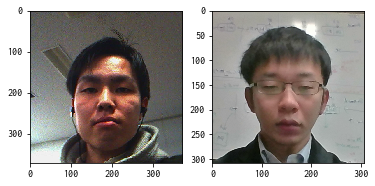

In [9]:
calc_dist_plot('takemoto0', 'taniai0')

# Plot

In [10]:
def extract_emb(data):
    emb = []
    for v in data.values():
        emb.append(v['emb'])
    emb = np.array(emb)
    return emb

In [11]:
X = extract_emb(data)
pca = PCA(n_components=3)
Xd = pca.fit(X).transform(X)

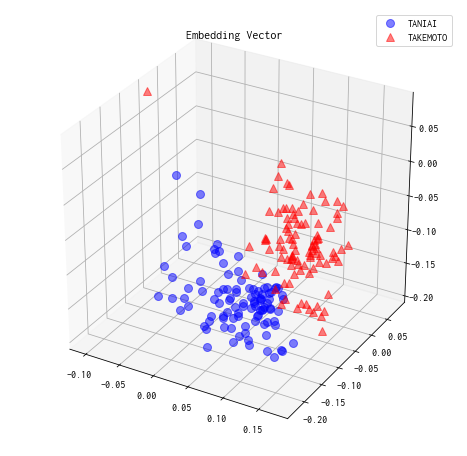

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(X[:100,0], X[:100,1], X[:100,2],
        'o', markersize=8, color='blue', alpha=0.5, label='TANIAI')
ax.plot(X[100:,0], X[100:,1], X[100:,2],
        '^', markersize=8, alpha=0.5, color='red', label='TAKEMOTO')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()